### Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import gwsurrogate
import numpy as np
import h5py
from astropy import constants as const
from scipy.interpolate import CubicSpline
from scipy.interpolate import InterpolatedUnivariateSpline
import math
from math import pi

## if you need the surrogate data: 
##gwsurrogate.catalog.pull('NRSur7dq4')

/Users/mokounkova/Library/Python/3.7/lib/python/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/Users/mokounkova/Library/Python/3.7/lib/python/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


### Helper functions

Functions for ramping waveforms, evaluating spin-weighted spherical harmonics, and computing and subtracting peak times

In [2]:
def Ramp(time, t_s, t_r):
    """ Ramp function for waveform with 5 continuous derivatives """
    if (time < t_s):
        return 0.0
    elif time > (t_s + t_r):
        return 1.0
    else:
        t = (time - t_s)/t_r
        return t**5*(126 + t*(-420 + t*(540 + t*(-315 + 70*t))))
    
def swsh(s, modes, theta, phi, psi=0):
    """
    Return a value of a spin-weighted spherical harmonic of spin-weight s. 
    If passed a list of several modes, then a numpy array is returned with 
    SWSH values of each mode for the given point.
    For one mode:       swsh(s,[(l,m)],theta,phi,psi=0)
    For several modes:  swsh(s,[(l1,m1),(l2,m2),(l3,m3),...],theta,phi,psi=0)
    """
    import spherical_functions as sf
    import quaternion as qt
    return sf.SWSH(qt.from_spherical_coords(theta, phi), s, modes) * np.exp(1j * s * psi)

def GetPeakTime(time, data): 
    """ Grab the peak time of some data """
    t_peak = time[np.argmax(data)]
    return t_peak

def SubtractPeakTime(time, data): 
    """ Subtract the peak time of some data """
    t_peak = GetPeakTime(time, data)
    return time - t_peak

### Read in the waveforms
Add mass, distance, and inclination to the waveform. Return plus and cross polarizations

In [3]:
## Read in the extrapolated modes
def ReadExtrapolatedModes(file, mass_msun, dist_kpc, theta, phi, dt, interpolate = True):
    """ 
        File is the file containing the extrapolated waveform that we want to read in 
        mass_msun is the total mass of the system in solar masses, and 
        dist_kpc is the distance to the system in kpc. 
        theta and phi are angles determining the inclination.
        dt is the timestep (reciprocal of the sampling rate)
        
        If we want to interpolate the waveform to have even timesteps dt, then 
        set interpolate to True. Otherwise, we'll return the data without 
        performing the interpolation """

    ## Read in the data
    f = h5py.File(file, 'r')
    
    ## grab the length of the waveform first
    data = f['Extrapolated_N2.dir']['Y_l2_m2.dat']
    time = np.array(data[:,0])
    
    h_plus = np.zeros(len(time))
    h_cross = np.zeros(len(time))

    ## Modes that you want to include in the projection.
    #modes = [(2, -2), (2,2)]
    modes = [(l,m) for l in range(2,5) for m in range(-l, l+1)]
    for mode in modes: 
        
        ## Grab the mode in question
        l = mode[0]
        m = mode[1]
        
        data = f['Extrapolated_N2.dir']['Y_l' + str(l) + '_m' + str(m) + '.dat']
        real = np.array(data[:,1])
        imag = np.array(data[:,2])
        coeff = real + 1j * imag
        
        ## Multiply by the corresponding spin-weighted spherical harmonic
        Ylm = swsh(-2, [(l,m)], theta=theta, phi=phi, psi=0) 
        h = coeff * Ylm 
        
        ## Add to our h_plus and h_cross computations
        h_plus = h_plus + np.real(h)
        h_cross = h_cross - np.imag(h) 
        
        
    ## Apply the astrophysical parameters
    time = time*mass_msun*const.G/(const.c**3)
    h_plus = h_plus*const.G*mass_msun/((const.c)**2*dist_kpc)
    h_cross = h_cross*const.G*mass_msun/((const.c)**2*dist_kpc)

    ## Taper the waveform and apply the ramp (need to start the waveform at zero for this)
    #time = time - time[0]
    #ramp = np.array([Ramp(t.value, 0.1, 0.3) for t in time])
    
    #h_plus = h_plus * ramp
    #h_cross = h_cross * ramp
    
    ## Now subtract off the peak time (this makes the spine interpolation easier)
    amp = np.sqrt(h_plus**2 + h_cross**2)
    time = time - time[np.argmax(amp)]
    
    if not interpolate:
        print("Not performing the interpolation")
        return time, h_plus, h_cross
    
    ## Now build the interpolants 
    cs_plus = InterpolatedUnivariateSpline(time, h_plus)
    cs_cross = InterpolatedUnivariateSpline(time, h_cross)

    ## Now create an evenly-spaced time array and interpolate the data 
    time_cs = np.arange(time[0].value, time[-1].value, dt)

    h_plus_cs = cs_plus(time_cs) 
    h_cross_cs = cs_cross(time_cs) 
    
    ## Return these new interpolated values
    return time_cs, h_plus_cs, h_cross_cs
    

### Evaluate the surrogate model to compare with NR data

In [4]:
## Load in the surrogate
sur = gwsurrogate.LoadSurrogate('NRSur7dq4')

/Users/mokounkova/Library/Python/3.7/lib/python/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Loaded NRSur7dq4 model


In [5]:
## Surrogate evaluation
def EvaluateSurrogate(q, chiA, chiB, mass, dist_mpc, theta, phi, dt):
    """ Evaluate the surrogate waveform 
        q is the mass ratio
        chiA is the dimensionless spin of the larger black hole
        chiB is the dimensionless spin of the smaller black hole
        mass is the total mass, in solar masses, of the system
        dist_mpc is the distance to the system in megaparsecs
        theta and phi determine the inclination angle and the polarization
        dt is 1 / the sampling rate
    """
    data = sur(q, chiA, chiB, dt = dt, units = 'mks', M = mass, dist_mpc = dist_mpc, f_low = 0, \
           inclination = theta, ellMax = 4, phi_ref = pi/2 - phi)

    time = data[0]
    h_plus = np.real(data[1])
    h_cross = -1 * np.imag(data[1])

    ## Ramp the surrogate
    time = time - time[0]
    ramp = np.array([Ramp(t, 0.27, 0.3) for t in time])

    h_plus = h_plus * ramp
    h_cross = h_cross * ramp

    ## Now subtract off the peak time 
    amp = np.sqrt(h_plus**2 + h_cross**2)
    time = time - time[np.argmax(amp)]

    return time, h_plus, h_cross
        

### Astrophysical parameters

In [6]:
## Masses, distances, and sample rates
dist_mpc = 400.0
dist_kpc = dist_mpc * 1000 * const.kpc
mass = 68.0 
mass_msun = mass * const.M_sun
sample_rate = 2048
dt = 1/sample_rate

## Inclination angle
theta = pi
phi = 0

## Extrinsic angle parameters
ra = 1.952318922
dec = -1.26967171703
pol = 0.824043851821

## Mass ratio and spins 
f_low = 0
q = 1.0
chiA = [0, 0, 0]
chiB = [0, 0, 0]

### Compute the waveforms we want

Not performing the interpolation


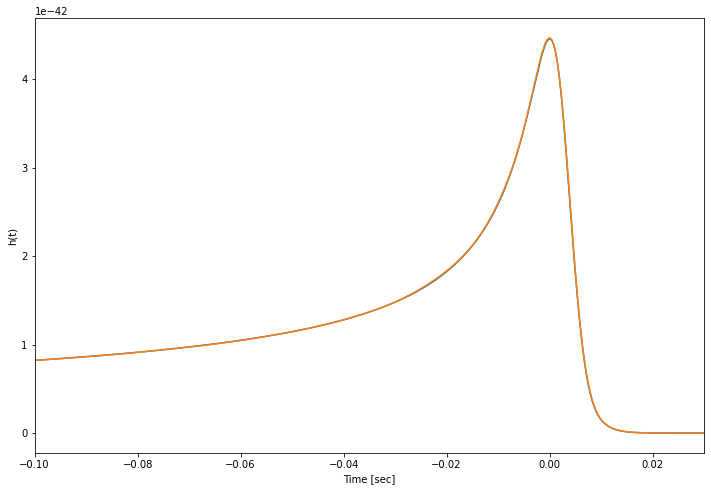

In [24]:
plt.figure(figsize=(12, 8))
time, h_plus, h_cross = ReadExtrapolatedModes('Waveforms/Lev2/EDGB_Strain_0p0.h5', mass_msun, dist_kpc, theta, phi, \
                                                    dt, interpolate = False)
    
plt.plot(time, h_plus**2 + h_cross**2) 

time_sur, h_plus_sur, h_cross_sur = EvaluateSurrogate(q, chiA, chiB, mass, dist_mpc, theta, phi, dt)

plt.plot(time_sur, h_plus_sur**2 + h_cross_sur**2)

plt.xlim(-0.1, 0.03)
plt.xlabel('Time [sec]')
plt.ylabel('h(t)')
plt.show()